# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import scipy as sp
from scipy.optimize import minimize

# Exercises

Todo: 1, 2, 5.

## Exercise 1
---
Determine the effect of stimulus sequence duration on RF estimates. To do this, repeat the above steps for different durations (5 s, 10 s, 20 s, 40 s, 80 s, 160 s, 320 s, 640 s). Compute the Pearson correlation between true and estimated RFs for each duration to quantify the accuracy of the estimator. The Pearson correlation $\mathrm{cc}$ is defined as
$$
\mathrm{cc} = \frac{\mathbf{k}_\mathrm{true}^T \hat{\mathbf{k}}}{\lVert \mathbf{k}_\mathrm{true} \rVert \lVert \hat{\mathbf{k}} \rVert}
$$
where $\lVert \cdot \rVert$ is the L2-norm (vector length).
As the response generation process is stochastic, compute the average correlation across 10 realizations for the same duration and plot the average correlation as a function of duration. How is the recording duration related to the ability to recover the true RF? 

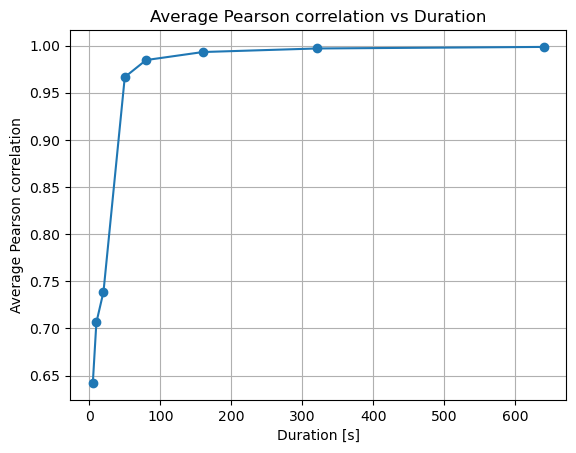

In [2]:
# Bunch of Parameters
durations = [5., 10., 20., 50., 80., 160., 320., 640.]
dt = .1
std_dev = 1
vf_size = (15,15)

mu = (8, 8) # center of the gabor patch
sigma = (4,4) #size of the gabor patch
angle = 45 # orientation of the gabor patch
frequency = .085 # spatial frequency of the gabor patch
phase = 0 # phase of the gabor patch

size = vf_size # size in pixel of our receptive field
xx, yy = np.meshgrid(1. + np.arange(size[0]),
                     1. + np.arange(size[1]))
# Gaussian envelope
G = np.exp(- np.power(xx - mu[0], 2) / (2. * sigma[0])
            - np.power(yy - mu[1], 2) / (2. * sigma[1]))

# spatial modulation
phi = np.deg2rad(angle)
xxr = xx * np.cos(phi)
yyr = yy * np.sin(phi)
xyr = (xxr + yyr) * 2. * np.pi * 2. * frequency
Sn = np.cos(xyr + phase)
K = G * Sn
K /= np.amax(np.abs(K))

noise_variance = 1
offset = 2.
cc_avg_list = []

for duration in durations:
    cc_list = []
    for _ in range(10):  # Repeat 10 times for each duration
        n_bins = round(duration / float(dt))
        S = std_dev * np.random.randn(n_bins, vf_size[0], vf_size[1])
        S_flat = S.reshape(S.shape[0], S.shape[1]*S.shape[2])
        S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))

        K_flat = K.ravel()
        K_flat = np.hstack((K.flat, offset))

        ks = np.dot(K_flat, S_flat.T)
        rate = ks + np.sqrt(noise_variance) * np.random.randn(n_bins)

        K_hat = np.linalg.pinv(S_flat.T @ S_flat) @ (S_flat.T @ rate)
        K_hat = K_hat[:-1].reshape(vf_size)
        K_hat_flat = K_hat.ravel()
        K_hat_flat_offset = np.hstack((K_hat_flat, offset))
        
        # These give the same results
        # cc = np.inner(K.ravel(), K_hat_flat) / (np.linalg.norm(K.ravel()) * np.linalg.norm(K_hat_flat)) 
        cc = sp.stats.pearsonr(K_flat, K_hat_flat_offset)[0]
        cc_list.append(cc)
        
    cc_avg = np.mean(cc_list)
    cc_avg_list.append(cc_avg)

plt.plot(durations, cc_avg_list, marker='o')
plt.xlabel('Duration [s]')
plt.ylabel('Average Pearson correlation')
plt.title('Average Pearson correlation vs Duration')
plt.grid(True)
plt.show()


We see that as the recording duration increases the Pearson correlation also increases (limit 1) between true and estimated RFs. After about ~50 seconds the correlation already surpasses 0.95. Increasing the duration from that point has significant diminishing returns. We can therefore conclude that a recording time of around a minute is enough to get accurate predictions of the true RF values.

## Exercise 2
---
Determine the effect of response noise ($\sigma^2$) on RF estimates. Try different value for the noise variance in the simulations, e.g., 0, 2, 4, 6, 8, and 10 for a duration of 100 s. As in the previous excercise, repeatedly estimate RF parameters for each condition (10 times) but this time also plot the standard deviation of the correlations across the different runs for each condition.

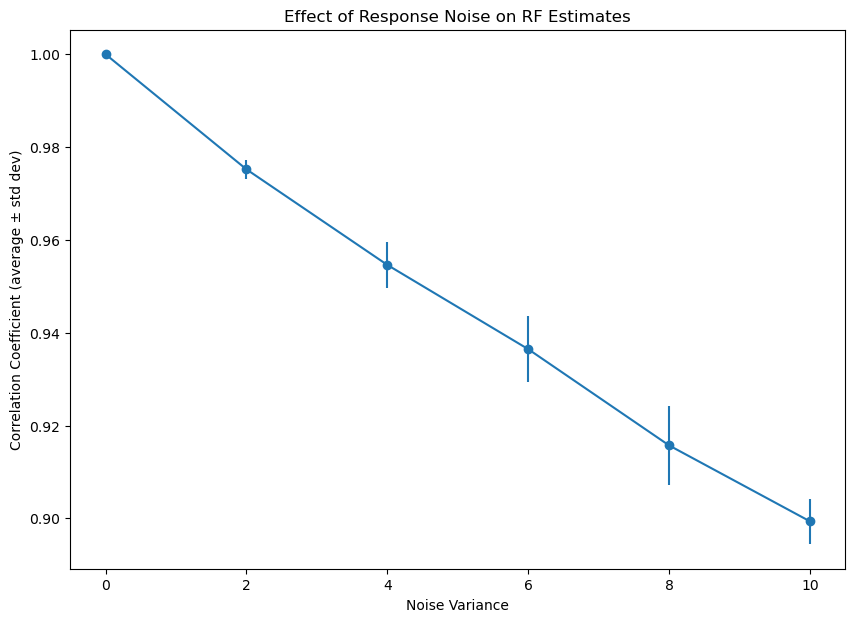

In [3]:
noise_variances = [0, 2, 4, 6, 8, 10]

duration = 100.0
n_bins = round(duration / float(dt))

cc_avg_list = []
cc_std_list = []

for noise_variance in noise_variances:
    cc_list = []
    for _ in range(10):
        S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])

        S_flat = S.reshape(S.shape[0],S.shape[1]*S.shape[2])
        S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))

        ks = np.dot(K_flat, S_flat.T)

        rate = ks
        rate = rate + np.sqrt(noise_variance) * np.random.randn(n_bins)

        K_hat = np.linalg.pinv(S_flat.T @ S_flat) @ (S_flat.T @ rate)
        K_hat = K_hat[:-1].reshape(vf_size)        
        K_hat_flat = K_hat.ravel()
        K_hat_flat = np.hstack((K_hat_flat, offset))

        cc = sp.stats.pearsonr(K_flat, K_hat_flat)[0]
        cc_list.append(cc)

    cc_avg = np.mean(cc_list)
    cc_std = np.std(cc_list)
    
    cc_avg_list.append(cc_avg)
    cc_std_list.append(cc_std)

plt.figure(figsize=(10,7))

plt.errorbar(noise_variances, cc_avg_list, yerr=cc_std_list, fmt='-o')
plt.xlabel("Noise Variance")
plt.ylabel("Correlation Coefficient (average ± std dev)")
plt.title("Effect of Response Noise on RF Estimates")
plt.show()

Here we see that the correlation coefficient decreases with an increase in the noise variance. The decrease is inversly proportional to the noise variance. We also see an increase in the standard deviation of the Pearson correlation with an increase in noise. All as you would expect. More randomness means less correlation and a bigger uncertainty.

## Exercise 3
---
What happens if the neural response is related to the filtered stimulus by a nonlinear function  $r = f_\mathrm{nonlinear}(\mathbf{k}^T \mathbf{s})$, e.g., by setting the `f_nonlin` argument in the data generation function to `f_threshold_quadratic` in excercise 1? Why does the linear estimator still provide a reliable estimate of the true RF? What happens if you use a full quadratic nonlinearity and set the `offset` term to 0? For more details, see Sharpee Ann Rev Neurosci (2013) (link in "Background" section).

## Exercise 4
---
Look at the analytical derivation of the log-likelihood for the poisson GLM.
Which of the terms are required for maximizing the likelihood with respect to $\mathbf{k}$ and which terms can be ignored? **Note:** due to the independence of spikes in the different bins, the likelihood can be written as $P(R | S, \mathbf{k}) = \prod_t^T P(r_t | \mathbf{s}_t, \mathbf{k})$. The log turns the product into a sum which makes life much easier. 




## Exercise 5
---
Explore the effect of the data duration and the firing rate on the goodness of fit of the Poisson GLM.

A - Generate data with durations of 10,20,50,100 and 200 seconds. Fit the model on each dataset and plot the fitted parameters.
Use the pearson correlation as a proxy of the goodness of fit, and plot it as a function of the duration of the data.

B - Fix the duration to 100s, and change the average firing rate of the simulation. How does the fit perform for different firing rates? 

### A

In [4]:
# Defining some functions for later use

def generate_inhomogeneous_poisson_spikes(lamda, dt):

    n_bins = lamda.shape[0]
    bins = np.arange(n_bins+1)*dt

    # generate Poisson distributed numbers for all bins with the max. intensity (lamda_max)
    lamda_max = np.max(lamda)
    poisson_numbers = np.random.poisson(lamda_max, size=n_bins)

    # throw away numbers depending on the actual intensity ("thinning")
    spike_times = []
    prob = lamda / lamda_max
    for i in range(n_bins):
        
        # number of spikes to keep in this bin
        n = np.sum(np.random.rand(poisson_numbers[i]) < prob[i])
        n_s = int(round(n * dt))

        # generate random spike times in this bin
        ts = bins[i] + np.random.rand(n_s)*dt

        spike_times.extend(ts)

    return np.asarray(spike_times)

# define functions for minimisation
def cost(k, spike_counts, S,alpha=1):
    #negative loglikelihood function to minimize
    ks = np.dot(k, S.T)
    lamda = np.exp(ks)
    return -np.dot(spike_counts, ks) + dt * np.sum(lamda)
    
def grad(k, spike_counts, S):
    # expression of the gradient of the negative log likelihood (note the sign is flipped accordingly)

    ks = np.dot(k, S.T)
    lamda = np.exp(ks)
    return -np.dot(S.T, spike_counts - dt*lamda)

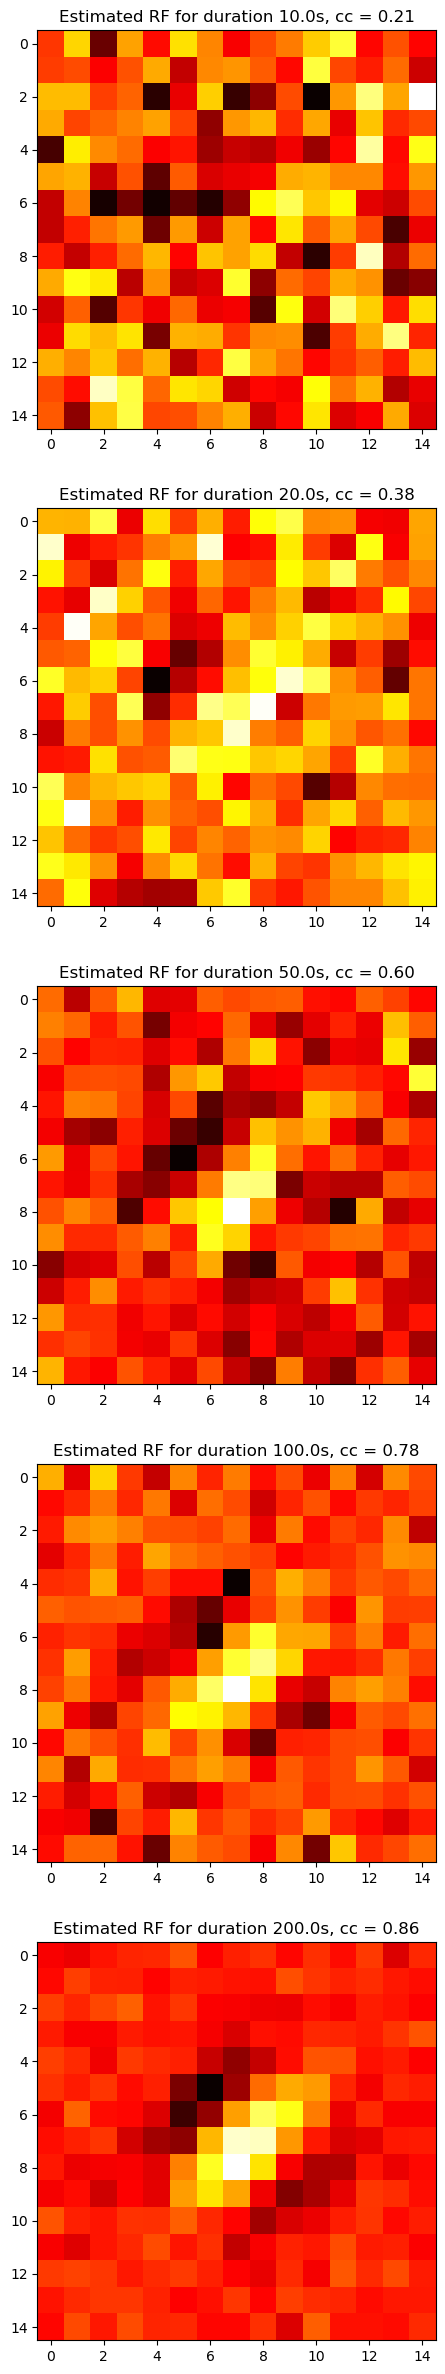

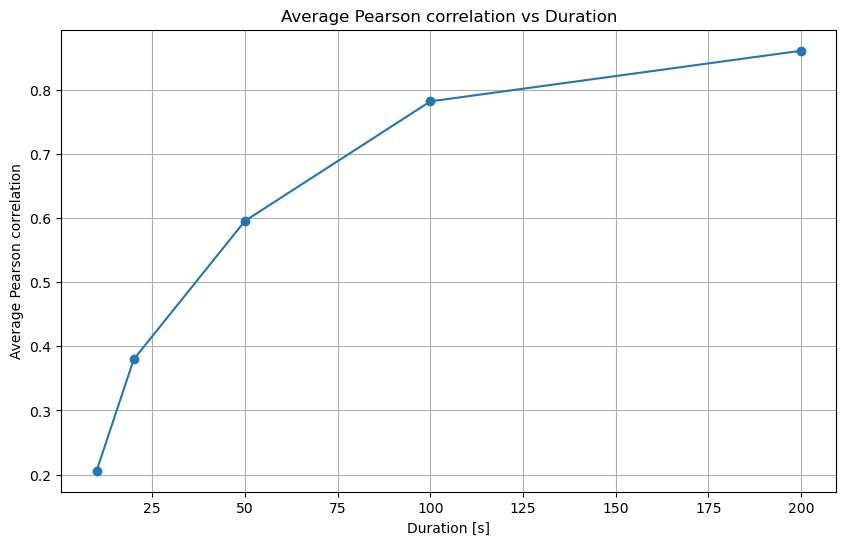

In [5]:
# Bunch of Parameters
durations = [10., 20., 50., 100., 200.]
cc_avg_list = []

dt = .1
std_dev = 1
vf_size = (15,15)

spike_rate = 5 # average firing rate 
fig, axs = plt.subplots(len(durations), figsize=(10, 6*len(durations)))

for idx, duration in enumerate(durations):
    cc_list = []
    K_est_list = []
    for _ in range(10):  # Repeat 10 times for each duration
        n_bins = round(duration / float(dt))
        S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])
        
        # flatten the matrices in to 1d array for convenience
        K_flat = K.ravel()
        K_flat = np.hstack((K.flat, offset))

        S_flat = S.reshape(S.shape[0],S.shape[1]*S.shape[2])
        S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))
        
        # 1. linear stage
        ks = np.dot(K_flat, S_flat.T)

        # 2. nonlinear stage (for a linear model: f -> identity function)
        lamda = np.exp(ks)
        expected_rate = np.sum(lamda*dt) / duration
        lamda *= (spike_rate / expected_rate)

        # generate spike times using an inhomogeneous Poisson process
        spike_times = generate_inhomogeneous_poisson_spikes(lamda, dt)

        # compute spike counts in the different time bins
        spike_counts = np.histogram(spike_times, bins=np.arange(n_bins+1)*dt)[0]

        k_STA = np.inner(S_flat.T, spike_counts) / np.sum(spike_counts)
        res = minimize(fun = cost, x0 = k_STA / 10, args = (spike_counts, S_flat), method = 'Newton-CG', jac = grad)

        K_est = res.x
        K_est_list.append(K_est[:-1].reshape(vf_size))  # Store K_est for averaging

        cc = np.inner(K.ravel(), K_est[:-1]) / (np.linalg.norm(K.ravel()) * np.linalg.norm(K_est[:-1]))
        cc_list.append(cc)
        
    K_est_avg = np.mean(K_est_list, axis=0)  # Compute the average K_est over the 10 runs
    
    cc_avg = np.mean(cc_list)
    cc_avg_list.append(cc_avg)
    
    # Plot K_est for this run
    axs[idx].imshow(K_est[:-1].reshape(vf_size), cmap='hot', interpolation='nearest')
    axs[idx].set_title(f"Estimated RF for duration {duration}s, cc = {cc_avg:.2f}")
        
    
plt.figure(figsize=(10, 6)) 
plt.plot(durations, cc_avg_list, marker='o')
plt.xlabel('Duration [s]')
plt.ylabel('Average Pearson correlation')
plt.title('Average Pearson correlation vs Duration')
plt.grid(True)
plt.show()


Here we see that there is a considerable increase in the Pearson correlation values, as well in the plots quality, as the duration increases. The increase is not as steep as with the linear Gaussian model however.

### B

C:\Users\yoris\AppData\Local\Temp\ipykernel_5848\2123556841.py:39: RuntimeWarning: overflow encountered in exp
  lamda = np.exp(ks)
C:\Users\yoris\AppData\Local\Temp\ipykernel_5848\2123556841.py:32: RuntimeWarning: overflow encountered in exp
  lamda = np.exp(ks)


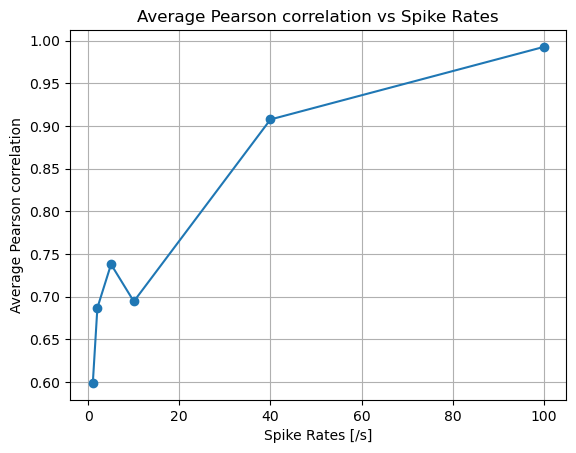

In [6]:
duration = 100.0
spike_rates = [1, 2, 5, 10, 40, 100]

cc_avg_list = []

dt = .1
std_dev = 1
vf_size = (15,15)


# Bunch of Parameters
durations = [10., 20., 50., 100., 200.]
cc_avg_list = []

dt = .1
std_dev = 1
vf_size = (15,15)

spike_rate = 5 # average firing rate 

for idx, spike_rate in enumerate(spike_rates):
    cc_list = []
    for _ in range(10):  # Repeat 10 times for each duration
        n_bins = round(duration / float(dt))
        S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])
        
        # flatten the matrices in to 1d array for convenience
        K_flat = K.ravel()
        K_flat = np.hstack((K.flat, offset))

        S_flat = S.reshape(S.shape[0],S.shape[1]*S.shape[2])
        S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))
        
        # 1. linear stage
        ks = np.dot(K_flat, S_flat.T)

        # 2. nonlinear stage (for a linear model: f -> identity function)
        lamda = np.exp(ks)
        expected_rate = np.sum(lamda*dt) / duration
        lamda *= (spike_rate / expected_rate)

        # generate spike times using an inhomogeneous Poisson process
        spike_times = generate_inhomogeneous_poisson_spikes(lamda, dt)

        # compute spike counts in the different time bins
        spike_counts = np.histogram(spike_times, bins=np.arange(n_bins+1)*dt)[0]

        k_STA = np.inner(S_flat.T, spike_counts) / np.sum(spike_counts)
        res = minimize(fun = cost, x0 = k_STA / 10, args = (spike_counts, S_flat), method = 'Newton-CG', jac = grad)

        K_est = res.x
        K_est_list.append(K_est[:-1].reshape(vf_size))  # Store K_est for averaging

        cc = np.inner(K.ravel(), K_est[:-1]) / (np.linalg.norm(K.ravel()) * np.linalg.norm(K_est[:-1]))
        cc_list.append(cc)   
       
    cc_avg = np.mean(cc_list)
    cc_avg_list.append(cc_avg)
       

plt.plot(spike_rates, cc_avg_list, marker='o')
plt.xlabel('Spike Rates [/s]')
plt.ylabel('Average Pearson correlation')
plt.title('Average Pearson correlation vs Spike Rates')
plt.grid(True)
plt.show()


We see a similar increase in the correlation score with an increase in spike rate compared to the plots versus data duration. Which is to be expected since with more spikes there is also more information to decode such that the approximation/estimation becomes better. However there is one big notaceable difference. We see a decrease with spike_rate = 10, compared to spike_rate = 5. This could simply be an artifact of the stochastic nature of the process. Yet, since we are taking the average value over 10 runs, this seems somewhat unlikely. There could also be some strange resonance(s) in the system for certain spike rates. It does seem to be an anomaly considering the average trend is for the correlation factor to increase.